# Introduction

The following notebook is our solution to the Image Classification challenge of the couse Artificial Neural Networks and Deep Learning from Politecnico di Milano, A.Y. 2021/2022

The following code has been used to build our best model on the test set used during the development phase, several other models have been tried and clearly described in the full report of our decision process. In this notebooks there are references to paragraphs of the report in which we describe better how decisions have been taken and comparison whit different solution are taken into account

**During the final phase we load various of our top models and we observed a better test accuracy with a previous model that differs from this one only in the lack of preprocessing. We think that differences between the two notebooks are minimum (only the VGG16 preprocessing is omitted), so we send only this notebook, which is significant of our work.**

Team name: romano_ercolani

*   Team name: romano_ercolani
*   Members: Romanò Francesco | Ercolani Antonio



# Data loading

Small section in which we load the dataset and we print a sample from each class of leaves

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/MyDrive/ANN-FIRST-CHALLENGE/

/gdrive/MyDrive/ANN-FIRST-CHALLENGE


In [ ]:
import os
from PIL import Image
import tensorflow as tf
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [ ]:
dataset_dir = 'dataset'

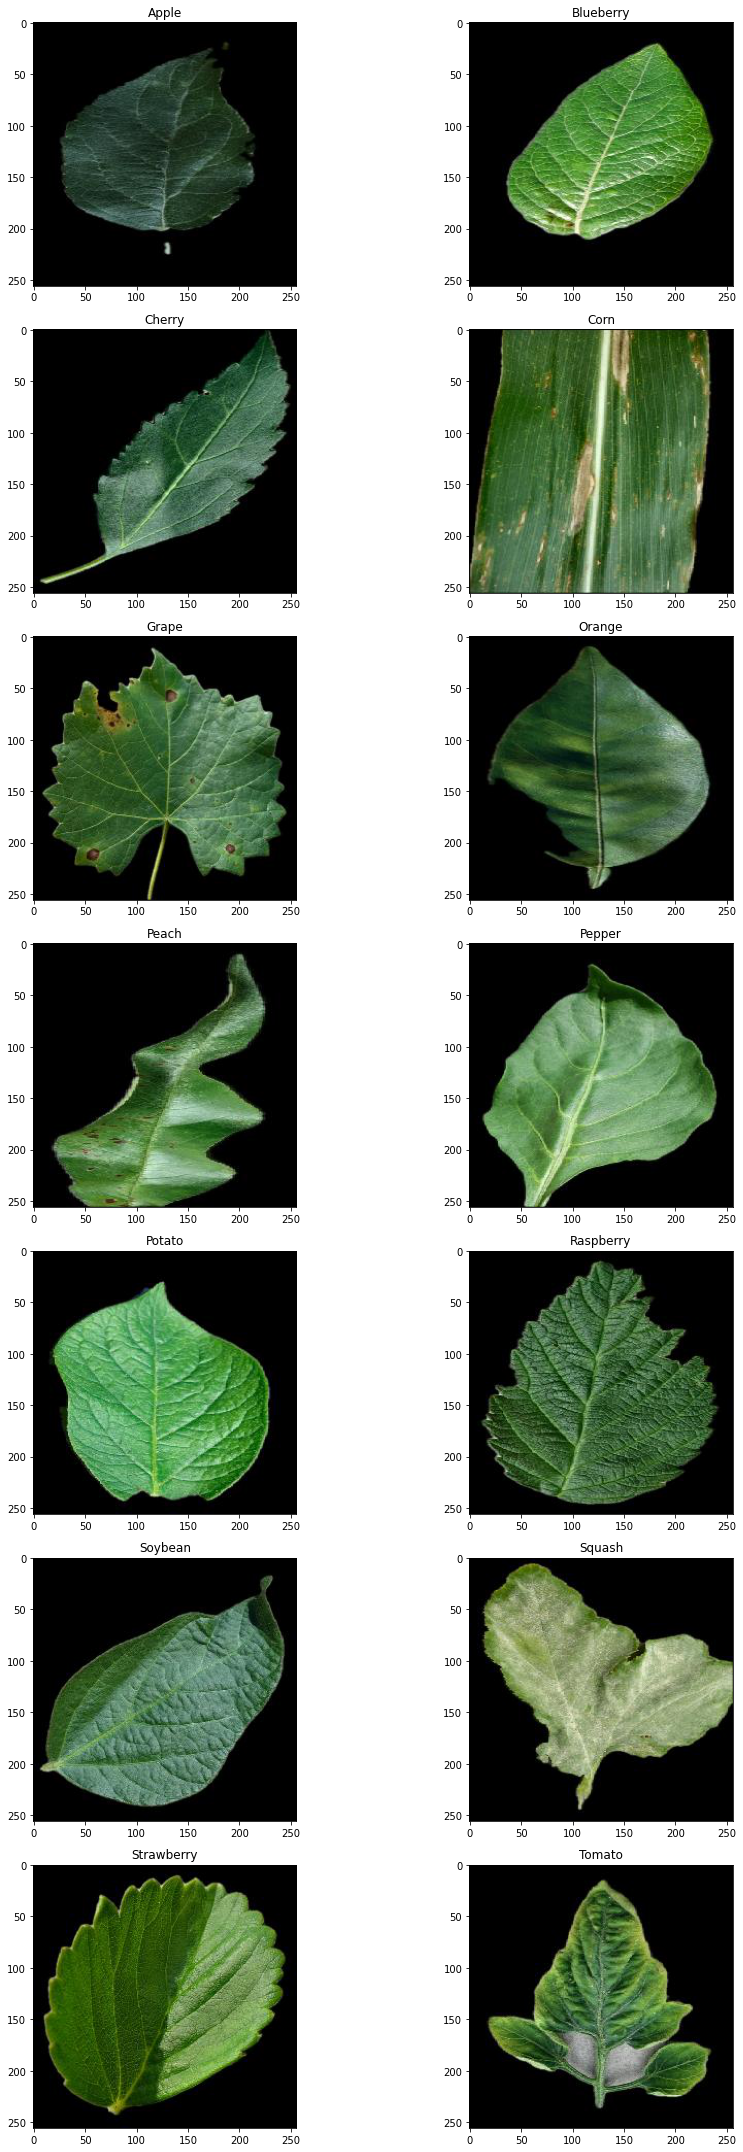

In [ ]:
# Plot example images from dataset
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

# Data Augmentation and preprocessing

We prepare our dataset and performs data augmentation and preprocessing on input images. Section 3 and last part of Section 4 of the report

In [ ]:
# Random seed is set for reproducibility of results
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
# Set batch size to 128
batch_size = 128

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.applications.vgg16 import preprocess_input

# We instantiate two ImageDataGenerator objects in order to perform data augmentation only on the training set and not in the validation one.
# As preprocessing we are using a preprocessing function ad-hoc for VGG16 models (as explained at the end of Section 4 of the report)

# In this first generator we set ranges of transormations used for data augmentation on the training set
train_data_gen = ImageDataGenerator(rotation_range=30,
                                    height_shift_range=50,
                                    width_shift_range=50,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True, 
                                    fill_mode='constant', cval=0, # IN CLASS fill_mode='reflect'
                                    validation_split=0.2,
                                    preprocessing_function=preprocess_input) # preprocessing added here

# In this second generator we just perform preprocessing and split data always in 80/20 with same seed in order to have the exact same split (no overlap of samples between training and validation)
valid_data_gen = ImageDataGenerator(validation_split=0.2, preprocessing_function=preprocess_input) # preprocessing also in the validation set

#We now use the generator to create a flow of the data points that we will use for training the model
aug_train_gen = train_data_gen.flow_from_directory(directory=dataset_dir,
                                         target_size=(256,256),
                                         color_mode='rgb',
                                         classes=None,
                                         class_mode='categorical',
                                         batch_size=batch_size,
                                         shuffle=True,
                                         seed=seed,
                                         subset='training')

valid_gen = valid_data_gen.flow_from_directory(directory=dataset_dir,
                                         target_size=(256, 256),
                                         color_mode='rgb',
                                         classes=None,
                                         class_mode='categorical',
                                         batch_size=batch_size,
                                         shuffle=True,
                                         seed=seed,
                                         subset='validation')


Found 14189 images belonging to 14 classes.
Found 3539 images belonging to 14 classes.


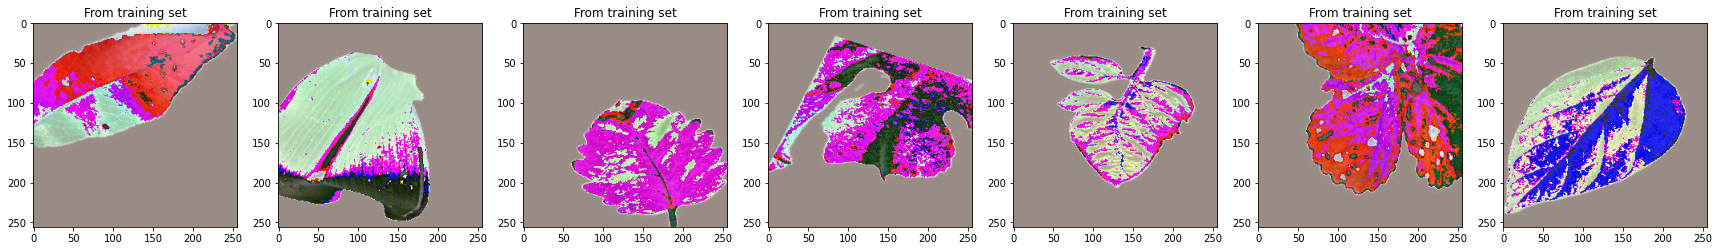

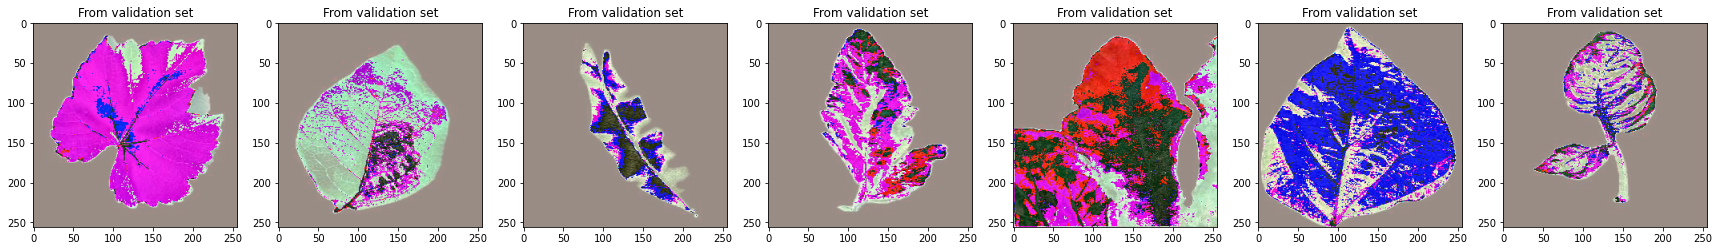

In [ ]:
# Here we just explore the results of our Augmentation and Preprocessing phase to see if trasformations have a sense
# We can notice that transormations are applied only over the training set and that instead preprocessing (which is clearly visible from the colours) is applied on both, as we want

train_batch = next(aug_train_gen)
valid_batch = next(valid_gen)

fig, ax = plt.subplots(1, 7, figsize=(30,45))
for i in range(0,7):
  ax[i].imshow(np.uint8(train_batch[0][i]))
  ax[i].set_title("From training set")

fig, ax = plt.subplots(1, 7, figsize=(30,45))
for i in range(0,7):
  ax[i].imshow(np.uint8(valid_batch[0][i]))
  ax[i].set_title("From validation set")

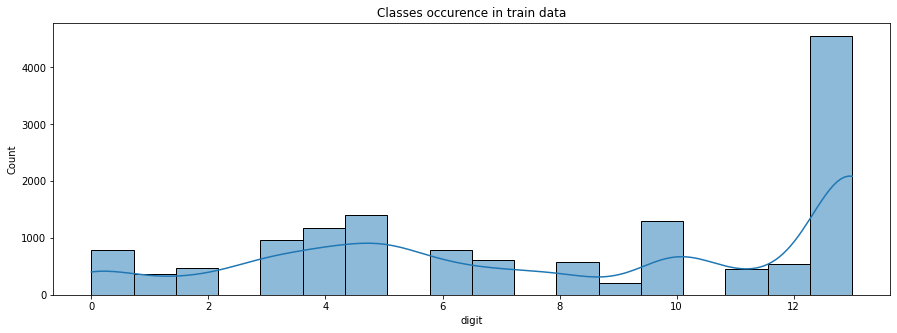

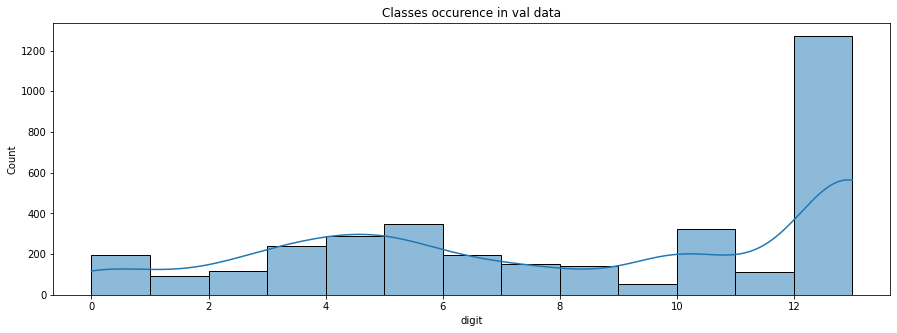

In [ ]:
# Simple exploration of dataset to look how the classes samples are distributed
# Plot class distribution in training and validation data
plt.figure(figsize=(15,5))
sns.histplot(data=pd.DataFrame(aug_train_gen.classes, columns=['digit']), x='digit', kde=True)
plt.title("Classes occurence in train data")
plt.show()

plt.figure(figsize=(15,5))
sns.histplot(data=pd.DataFrame(valid_gen.classes, columns=['digit']), x='digit', kde=True)
plt.title("Classes occurence in val data")
plt.show()

# Obs: class distribution is preserved in train and val data

In [ ]:
# Models metadata used to build and train the model
input_shape = (256, 256, 3)
epochs = 200

# Transfer Learning VGG16

Transfer Learning of the pre-trained model VGG16. Section 2 of the report

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

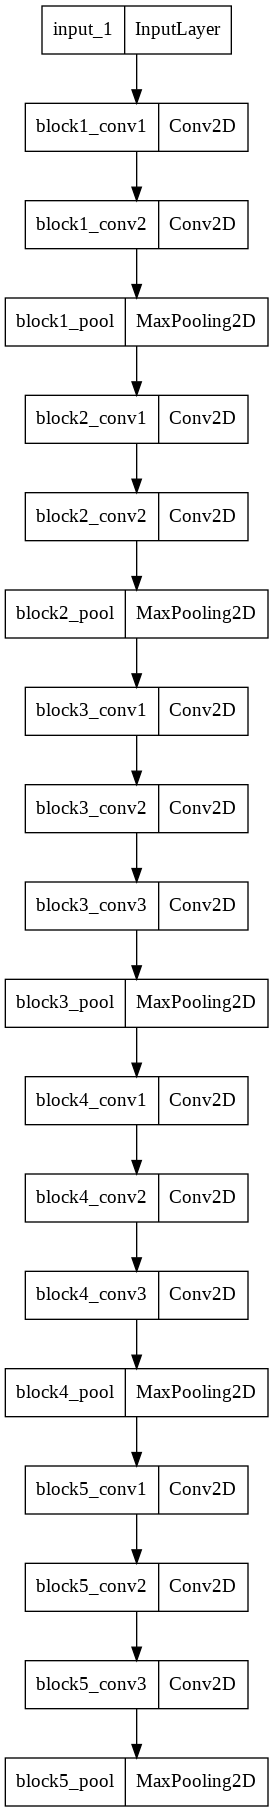

In [ ]:
# Model transferred: vgg16
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

# Fine Tuning

Here we set as trainable the last 4 layers of the VGG16 feature extractor part. Section 4 of the report

In [ ]:
# Set the trainable layers for the fine tuning

supernet.trainable = True

for i, layer in enumerate(supernet.layers[:15]):
  layer.trainable=False

for i, layer in enumerate(supernet.layers):
   print(i, layer.name, layer.trainable)
supernet.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0       

# Dense top classifier and GAP layer

Here we build our classifier used for the final classification after the extraction of features performed by the Fine Tuned VGG16 model. Section 2.1 of the report

In [ ]:
# Create the classifier dense at top of vgg16

inputs = tfk.Input(shape=(256,256,3))
x = supernet(inputs)
x = tfkl.GlobalAveragePooling2D()(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    14, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 14)                3598      
                                                             

# Dealing with class imbalance

As seen above the dataset present a bias towards the various classes. Our simple solution to this problem is the creation of class weights, that gives more importance to samples of minority classes and less to majority classes. Section 2.2 of the report

In [ ]:
# Considering class imbalance: class weightning
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(aug_train_gen.classes),
                                        y = aug_train_gen.classes                                                   
                                    )
class_weights = dict(zip(np.unique(aug_train_gen.classes), class_weights))
class_weights

{0: 1.2812895069532237,
 1: 2.7098930481283423,
 2: 2.170235546038544,
 3: 1.050259067357513,
 4: 0.8684661525278492,
 5: 0.724446032880629,
 6: 1.2960358056265984,
 7: 1.6560457516339868,
 8: 1.768760907504363,
 9: 4.78066037735849,
 10: 0.7838360402165506,
 11: 2.2032608695652174,
 12: 1.8803339517625233,
 13: 0.2225027442371021}

# Training of the model

Finally we perform the training of the model using checkpoints and Early Stopping technique. At the end we plot training showing loss function and accuracy both of training and validation

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('Experiment_results')

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp'),
                                                     save_weights_only=False,
                                                     save_best_only=False)
  callbacks.append(ckpt_callback)

  # Early Stopping
  # --------------
  es_callback = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [ ]:
# Create folders and callbacks and fit
callbacks = create_folders_and_callbacks(model_name='VGG16_aug_preprocess_one_train')

# Train model with classes weighted to overcame class imbalance problems
history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = callbacks,
    class_weight = class_weights #added class weights here
).history

Epoch 1/200
111/111 [==============================] - 5980s 53s/step - loss: 1.1205 - accuracy: 0.6330 - val_loss: 0.4269 - val_accuracy: 0.8613
Epoch 2/200
111/111 [==============================] - 290s 3s/step - loss: 0.1993 - accuracy: 0.9290 - val_loss: 0.2146 - val_accuracy: 0.9336
Epoch 3/200
111/111 [==============================] - 289s 3s/step - loss: 0.1265 - accuracy: 0.9494 - val_loss: 0.1607 - val_accuracy: 0.9565
Epoch 4/200
111/111 [==============================] - 286s 3s/step - loss: 0.0850 - accuracy: 0.9656 - val_loss: 0.1496 - val_accuracy: 0.9522
Epoch 5/200
111/111 [==============================] - 287s 3s/step - loss: 0.0637 - accuracy: 0.9743 - val_loss: 0.1065 - val_accuracy: 0.9681
Epoch 6/200
111/111 [==============================] - 289s 3s/step - loss: 0.0583 - accuracy: 0.9789 - val_loss: 0.0956 - val_accuracy: 0.9717
Epoch 7/200
111/111 [==============================] - 288s 3s/step - loss: 0.0617 - accuracy: 0.9763 - val_loss: 0.0912 - val_accurac

In [ ]:
tl_model.save("Experiment_results/VGG16_data_aug_preprocess_one_train")

INFO:tensorflow:Assets written to: Experiment_results/VGG16_data_aug_preprocess_one_train/assets


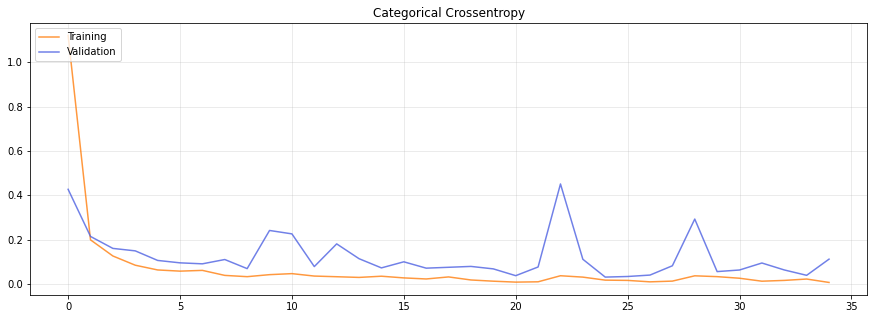

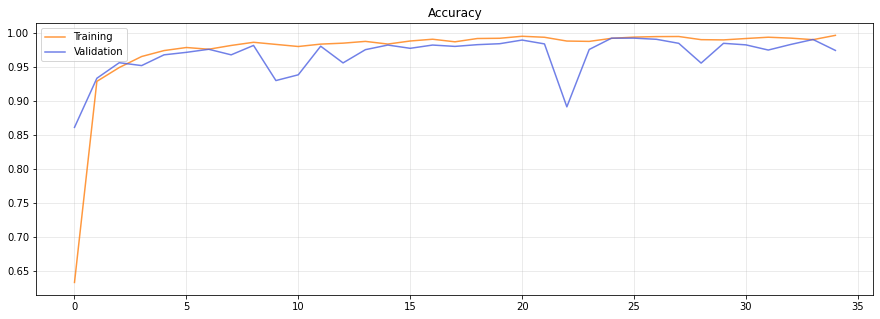

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

Notice that this is just one of the models tried, for a detailed description of other attempts we remind once again the report file

This model performs a score of 0.93 Mean Accuracy on the codalab public test set and it is our best model. A comparison between plots with one of the various models used before is present at the end of the report